In [7]:
import sys
sys.path.append('..')

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets.sequence_folders import SequenceFolder
from inverse_warp import Warper
from utils import tensor2array

In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
train_set = SequenceFolder(
            '/mnt/datasets/yasin/range-azimuth',
            train=True,
            sequence_length=3
        )

In [11]:
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=8, shuffle=True,
        num_workers=4, pin_memory=True)

In [42]:
dataset_iter = iter(train_loader)
tgt_img, ref_imgs = next(dataset_iter)
tgt_img = tgt_img.to(device)
ref_imgs = [img.to(device) for img in ref_imgs]

In [29]:
print(tgt_img.shape)
print(len(ref_imgs))
print(ref_imgs[0].shape)

torch.Size([8, 1, 256, 64])
2
torch.Size([8, 1, 256, 64])


In [32]:
warper = Warper(0.0977, 256, 64, 0)

In [43]:
pose = torch.tensor([0.5, 0.8, 0, 0,0,0])
print(pose.shape)
pose_batch = pose.repeat(8,1)
print(pose_batch.shape)
pose_batch = pose_batch.to(device)

torch.Size([6])
torch.Size([8, 6])


In [44]:
projected_img, valid_points = warper.inverse_warp_fft(ref_imgs[0], pose_batch)

/home/yasin/anaconda3/envs/pytorch17/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [52]:
print(projected_img.shape)

torch.Size([8, 1, 256, 64])


In [47]:
img_tgt = tensor2array(tgt_img[0], colormap='bone')
img_src = tensor2array(projected_img[0], colormap='bone')

In [53]:
img_tgt=img_tgt.transpose(1, 2, 0)
img_src=img_src.transpose(1, 2, 0)

print(img_tgt.shape)
print(img_src.shape)

(256, 64, 4)
(256, 64, 4)


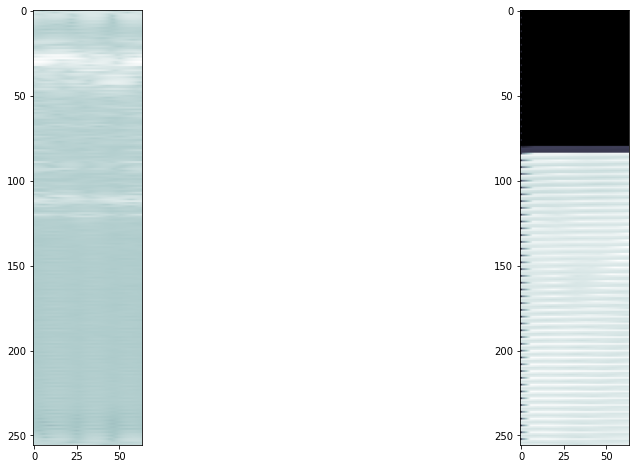

In [56]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img_tgt)
plt.subplot(122)
plt.imshow(img_src)